In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False

import pandas as pd
import glob
import os

DATA_PATH = "../../food"

# 요일 / 시간대 매핑
DAY_MAP = {
    1: '월', 2: '화', 3: '수', 4: '목',
    5: '금', 6: '토', 7: '일'
}

HOUR_MAP = {
    1: '00:00~06:59',
    2: '07:00~08:59',
    3: '09:00~10:59',
    4: '11:00~12:59',
    5: '13:00~14:59',
    6: '15:00~16:59',
    7: '17:00~18:59',
    8: '19:00~20:59',
    9: '21:00~22:59',
    10: '23:00~23:59'
}

use_cols = ["hour", "day", "card_tpbuz_nm_2", "amt", "cnt"]

files = sorted(glob.glob(os.path.join(DATA_PATH, "202*.csv")))
if not files:
    raise ValueError("CSV 파일을 찾지 못했습니다. 경로 확인 필요")

result = []

for file in files:
    print(f"처리 중: {os.path.basename(file)}")

    for chunk in pd.read_csv(file, usecols=use_cols, chunksize=500_000):
        # 🔑 핵심 전처리
        chunk["day_str"] = chunk["day"].map(DAY_MAP)
        chunk["hour_str"] = chunk["hour"].map(HOUR_MAP)

        agg = (
            chunk
            .groupby(
                ["hour_str", "day_str", "card_tpbuz_nm_2"],
                as_index=False
            )
            .agg({"amt": "sum", "cnt": "sum"})
        )

        result.append(agg)

df_time = (
    pd.concat(result, ignore_index=True)
    .groupby(
        ["hour_str", "day_str", "card_tpbuz_nm_2"],
        as_index=False
    )
    .agg({"amt": "sum", "cnt": "sum"})
)

df_time.head()


처리 중: 202201.csv
처리 중: 202202.csv
처리 중: 202203.csv
처리 중: 202204.csv
처리 중: 202205.csv
처리 중: 202206.csv
처리 중: 202207.csv


,hour_str,day_str,card_tpbuz_nm_2,amt,cnt
0,00:00~06:59,금,간이주점,4154538267,86778
1,00:00~06:59,금,고기요리,1015528294,22331
2,00:00~06:59,금,닭/오리요리,1108655803,36891
3,00:00~06:59,금,별식/퓨전요리,309842468,14713
4,00:00~06:59,금,분식,622710298,57642


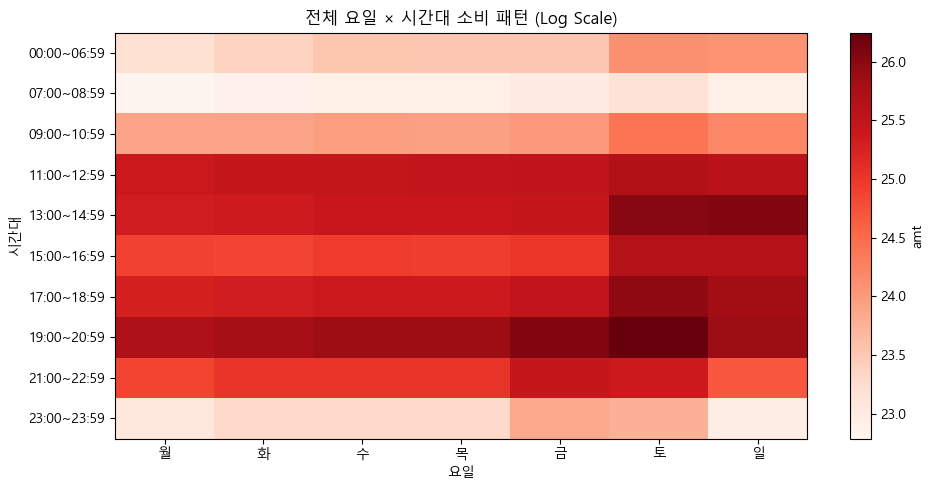

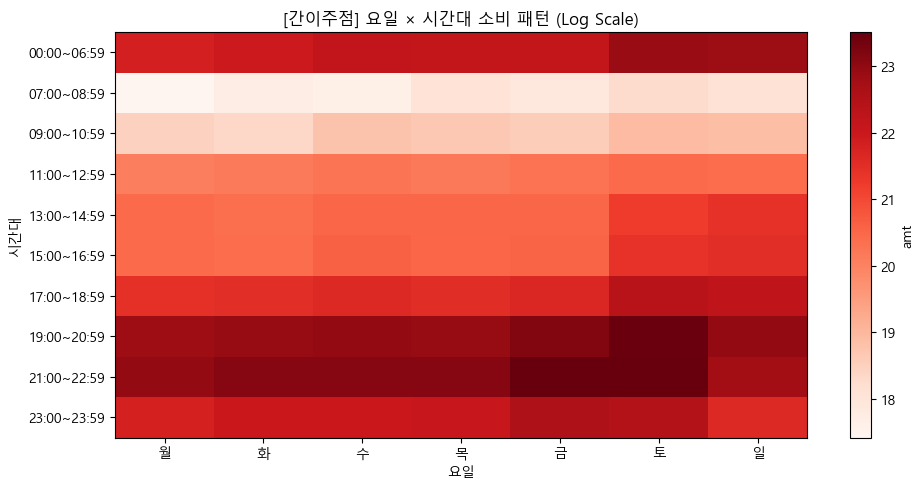

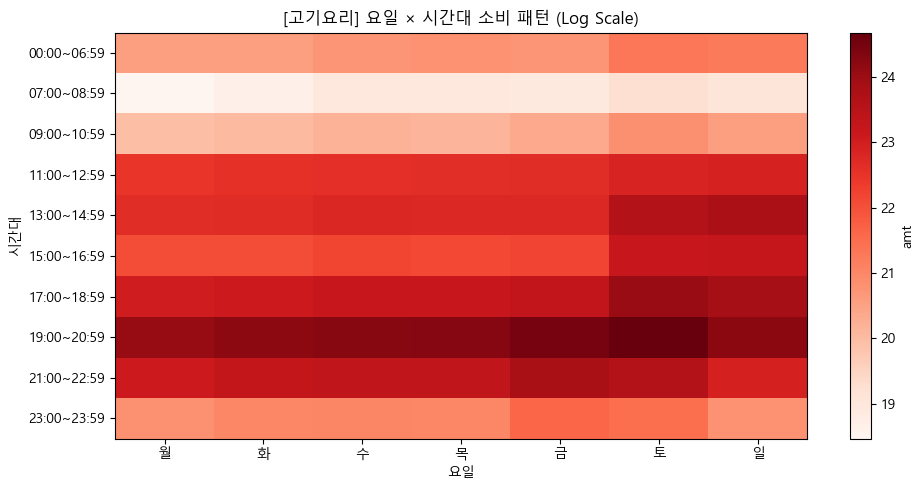

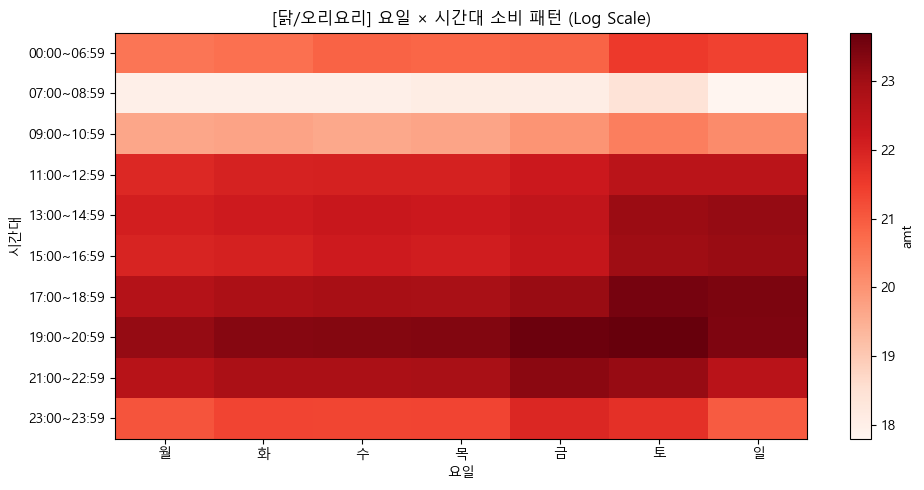

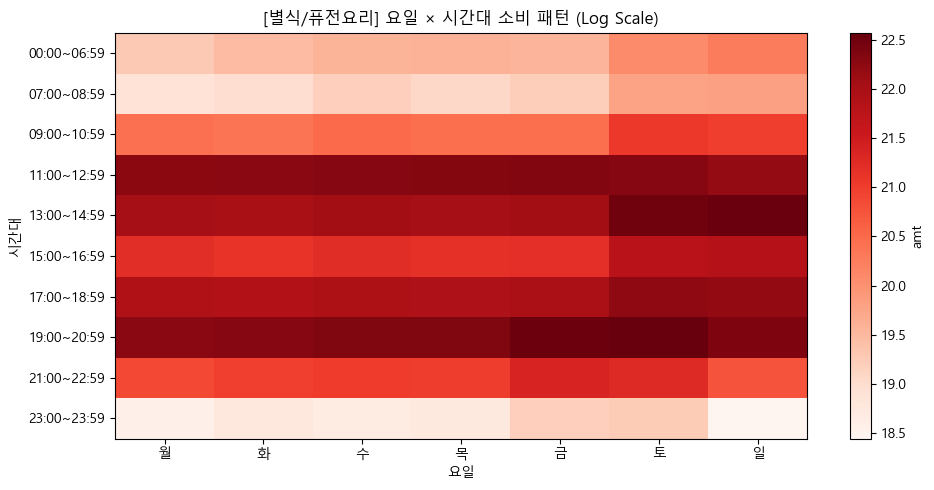

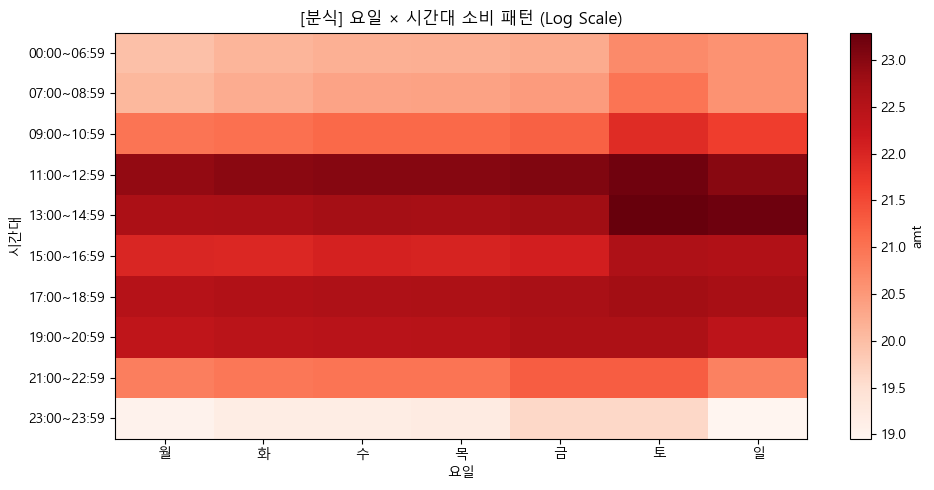

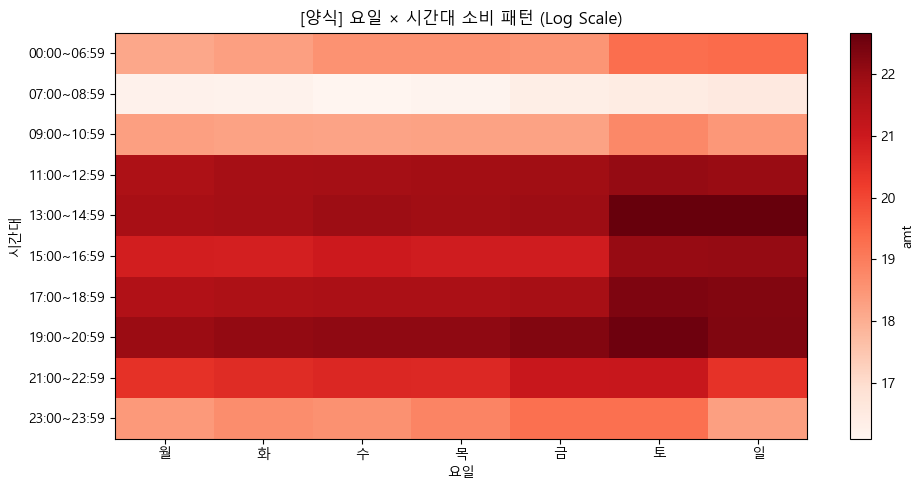

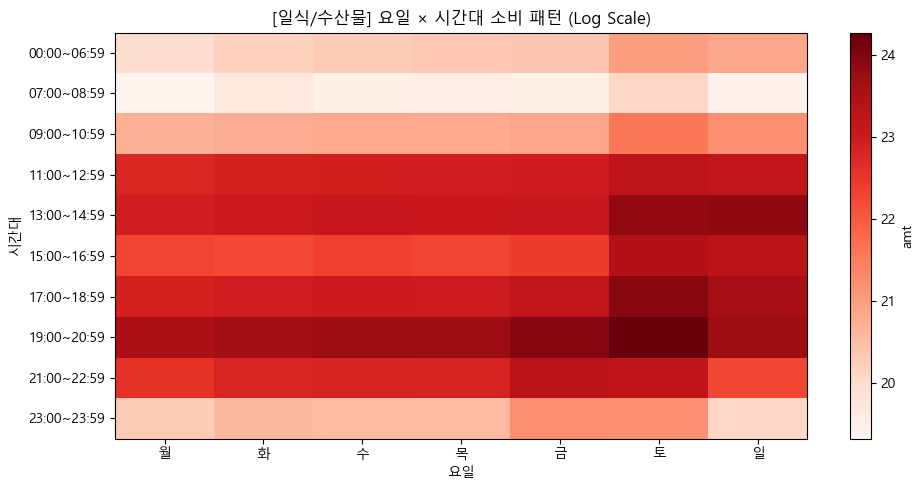

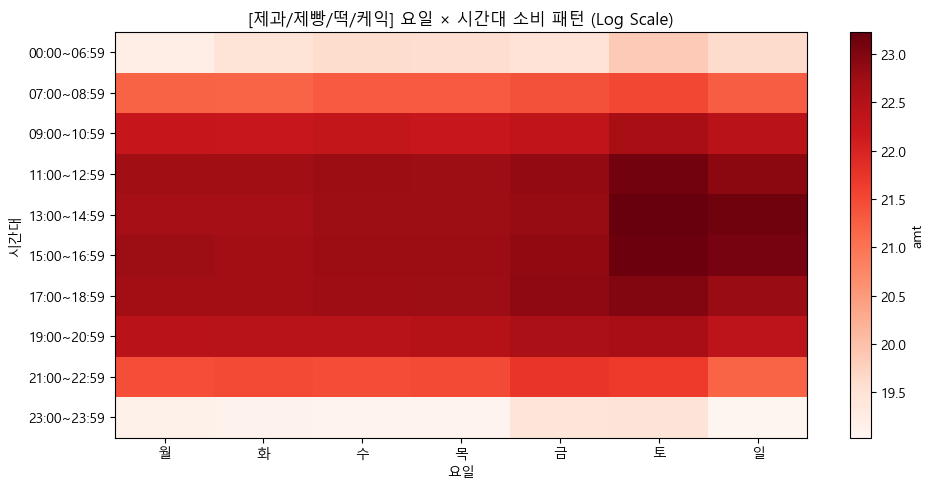

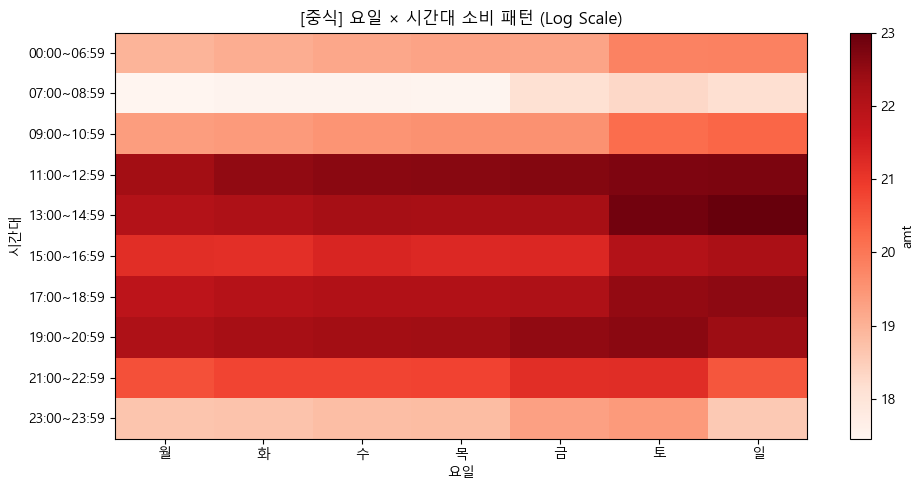

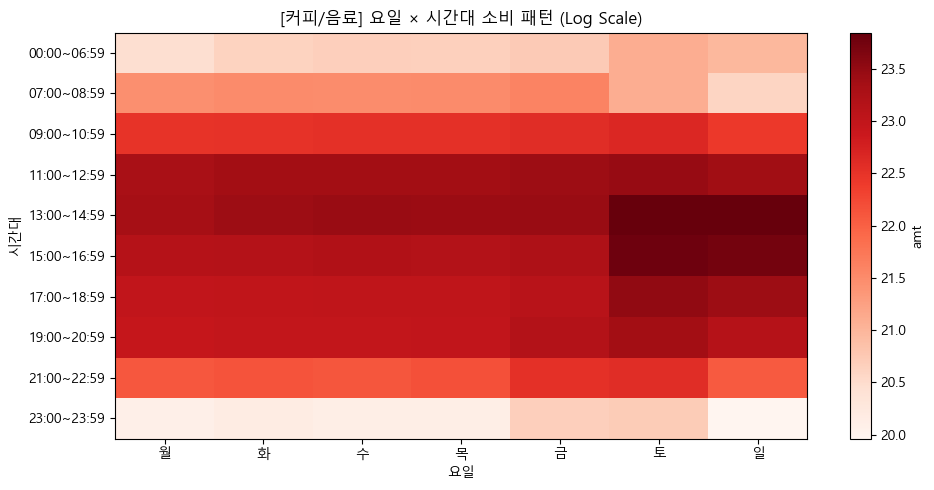

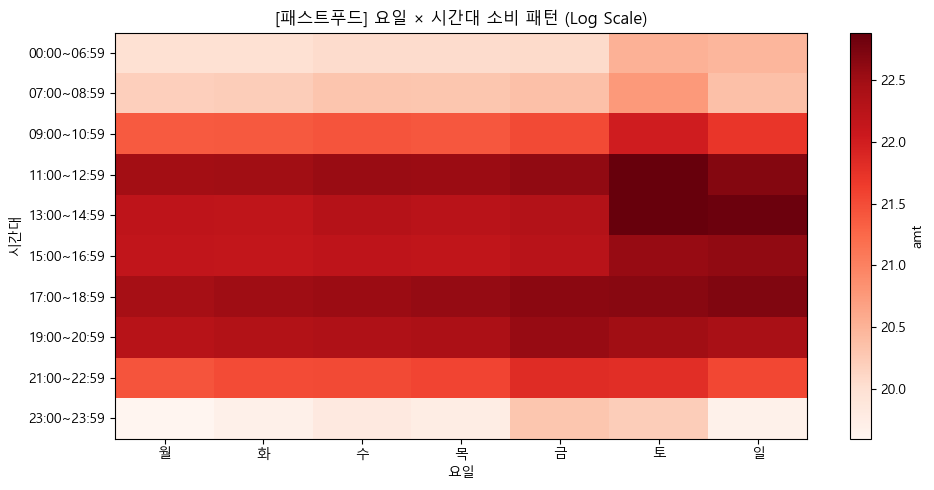

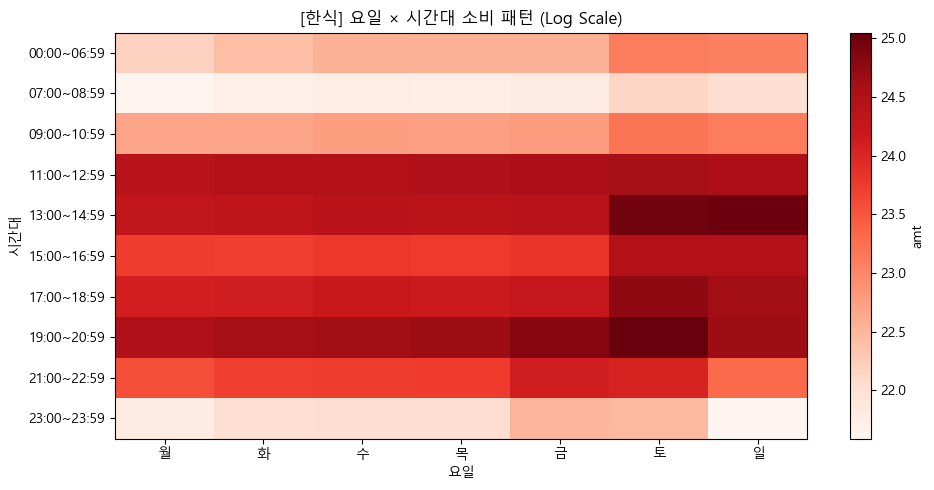

In [8]:
import numpy as np

DAY_ORDER = ['월', '화', '수', '목', '금', '토', '일']
HOUR_ORDER = [
    '00:00~06:59', '07:00~08:59', '09:00~10:59', '11:00~12:59',
    '13:00~14:59', '15:00~16:59', '17:00~18:59', '19:00~20:59',
    '21:00~22:59', '23:00~23:59'
]

def draw_heatmap(data, title, metric="amt", log_scale=True):
    pivot = (
        data
        .pivot_table(
            index="hour_str",
            columns="day_str",
            values=metric,
            aggfunc="sum"
        )
        .reindex(index=HOUR_ORDER, columns=DAY_ORDER)
        .fillna(0)
    )

    plot_data = np.log1p(pivot) if log_scale else pivot

    plt.figure(figsize=(10, 5))
    im = plt.imshow(
        plot_data,
        aspect="auto",
        cmap="Reds",
        vmin=plot_data.values.min(),
        vmax=plot_data.values.max()
    )

    plt.xticks(range(len(DAY_ORDER)), DAY_ORDER)
    plt.yticks(range(len(HOUR_ORDER)), HOUR_ORDER)
    plt.xlabel("요일")
    plt.ylabel("시간대")
    plt.title(title + (" (Log Scale)" if log_scale else ""))

    cbar = plt.colorbar(im)
    cbar.set_label(metric)

    plt.tight_layout()
    plt.show()

# 전체
draw_heatmap(df_time, "전체 요일 × 시간대 소비 패턴")

# 업종별
for category in sorted(df_time["card_tpbuz_nm_2"].unique()):
    sub = df_time[df_time["card_tpbuz_nm_2"] == category]
    draw_heatmap(sub, f"[{category}] 요일 × 시간대 소비 패턴")
